homomorphic:

图像M可以看作照射分量和反射分量相乘:

M = I x R

我们不用管I、R是什么、怎么算。

只要先对图像取对数

lM = ln(M)

然后对图像进行一次傅里叶变换

FFT(lM) = I' + R'

即可

retinex:

该方法需要估算 I

最后求 R

注意老师没有讲的部分是

1.需要将最后的结果线性拉伸，我这里用的是归一化到[0-255]区间
2.f(x) = ln(x)在计算时存在除以零的风险,这里我将ln(x)右移一个单位为ln(1+x)

由于是彩色图片，详情请到下一节2.10查看结果


同态滤波公式(详见Digital Image Processing 4th Edition):

huv = (Y_H - Y_L)*[1-e^(-cD^2(D_uv/D_0^2))] + Y_L

In [1]:
import sys
sys.path.append("../")
import npccv.fft as nft
import npccv.utils as utils
import numpy as np


class fftimg(nft.fftimg):
    #继承之前的类，完成同态滤波功能
    def homomorphic(self,yh,yl,d0,c=1):

        fftlf = nft.FFT2(np.log(self.img),depart=False)
        duv = utils.distMat(self.img,(-1,-1))

        import math
        huv = (yh-yl)*(1 - np.power(math.e,
                -1 * c * duv / (d0**2)
            )) + yl

        res = np.power(math.e,nft.iFFT2(huv * fftlf))

        return res

    def retinex(self,sigmaX=1,sigmaY=1,setRes = False):
        """
            retinex 滤波
            Parm:
                sigmaX和sigmaY是高斯二维正态分布的两个常数
        """
        import math
        hxy = np.zeros_like(self.img)
        wix = np.array([[i for i in range(self.W)] for j in range(self.H)])
        hix = np.array([[j for i in range(self.W)] for j in range(self.H)])

        hxy = np.power(wix,2)/(sigmaX**2) + np.power(hix,2)/(sigmaY**2)
        hxy = (1/(2*math.pi*sigmaX*sigmaY)) * np.power(math.e,-0.5 * hxy)

        lf = np.log(1e-5+self.img)
        lfh = np.log(1e-5+self.img*hxy)

        res = np.power(math.e,lf - lfh)

        #注意，这一步属于线性拉伸，我们得到的结果不在颜色范围内
        res = utils.Normalization(res) * 255

        if setRes:
            self.img = res
        
        return res


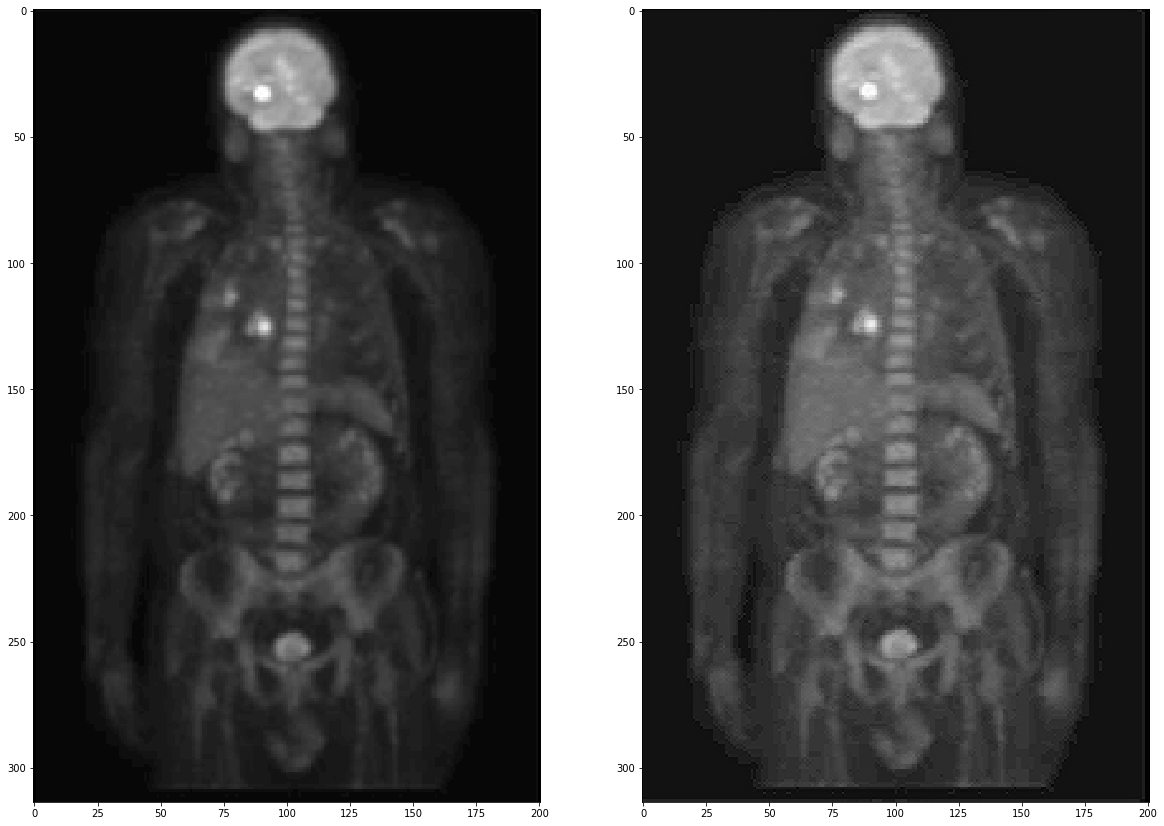

In [2]:
img = utils.readGray('../imgs/c2-2/homomorphic.png')
fimg = fftimg(img)
stm,pse = fimg.FSD()

funcs = [
        lambda img:img,
        lambda img:fimg.homomorphic(0.4,4.,d0=15,c=4),
    ]
utils.compare(img,funcs)